<a href="https://colab.research.google.com/github/mcstorey/martins-stuff/blob/master/Sim1_04Dec2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
Simulation 1: Particle motion in lane with sinusoidal walls

This Python program simulates the flow of an arbitrary number of 
non-interacting particles in a conservative lane with sinusoidal walls.

Reference article: 
    A simulation of particle motion in a lane with sinusoidal walls
    Martin Storey and Alec Lau, 2020.
    ArXiv xxx.xxx.xxx

Program overview:
    1. Run the specified number of simulations, adding them to the previous 
        simulation runs for the same set of parameters, if applicable.
    2. Display a sample trajectory from that series, the very last one. 
    3. Do a statistical analysis of all the runs done for this set of parameters,
        i.e. this series of runs and every previous one found in the data file; 
        present some of the results graphically. 

Output:
    A file
    Some figures

To run:
    1. Execute first cell, and go to the bottom of the cell, follow the link to 
        obtain a password, enter the password and press <return>
    2. After verifying that the simulation parameters are as desired, execute the 
        second cell.

In addition to the figures that appear, output files are available by clicking 
on the folder icon on the left hand side of the Colab window. 

Main parameters:
Lane geometry:
    wallWavelength = S in the article       
    wallAmplitude = A in the article
    avgRadius = Z0 in the article
Particle initialisation:
    initFlowVel = Vflow in the article
    velVariance = sigma^2 in the article
Simulation:
    numberOfSimulationRuns = N in the article
    singleRunTime = T in the article
    collisionPositionSolverPrecision: an indication of the precision of each 
    collision point position calculation
Visualisation:
    numHistBins
    numTimeIntervals_test = 100        

Program written by Alec Lau with Martin Storey and Jordan Hoffmann in 2020.
Significant updates on 4-Dec-2020, but work remains in progress

'''
################################################################################

# imports
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt 
from google.colab import drive 
import os
import csv
from datetime import datetime
drive.mount('/drive')

################################################################################

'''
Function initialize_particle_arrays. 
Assigns a random x and z position from a uniform distribution within the first 
one-wavelength cell of the lane. 
Assigns Rayleigh-distributed Vx and Vz velocity components  and adds 
on an initial flow rate in the X direction.
Also accepts user-specified positional and velocity components.

Parameters:
- wallWavelength = S in the article       
- wallAmplitude = A in the article
- avgRadius = Z0 in the article
- initFlowVel = Vflow in the article
- velVariance = sigma^2 in the article
- timestepNum, the number of time steps in the simulation (an int)
- xc (optional) = a custom x initial coordinate
- zc (optional) = a custom z initial coordinate
- vxc (optional) = a custom x initial velocity
- vzc (optional) = a custom z initial velocity

Returns:
- initial x coordinate in the first index
- initial z coordinate in the first index
- initial Vx velocity in the first index
- initial Vz velocity in the first index

Last Modified Dec-04, 2020 (Jordan Hoffmann)
- Cleaning code
- Modified initialization function to redo BOTH coordinates if out of range
- Changed to dictionary format
'''

def initialize_particle_arrays(laneSpecs, initCnsts, xc=None, zc=None,         \
                               vxc=None, vzc=None):
    
    # Generate a random X and Z component within the rectangle completely
    # enclosing the first wavelength, then redo both components if it lies
    # outside the wall (due to sinusoidal walls)
    initialX, initialZ = xc, zc
    laneDiameter = 2 * (laneSpecs["wallAmplitude"] + laneSpecs["avgRadius"])
    while True:
        if xc == None:
            # Random X coordinate from a uniform distribution
            initialX = laneSpecs["wallWavelength"] * np.random.random_sample()
        if zc == None:
            # Random Z coordinate from a uniform distribution 
            initialZ = laneDiameter*(np.random.random_sample() - 0.5)

        maxInitialZRange = wall_func(initialX, laneSpecs)
        if np.abs(initialZ) < maxInitialZRange:
            break

    # X and Z components of the velocities have normal distribution, 0 mean,    
    # same variance (input parameter). The X component then has an initial flow
    # added to it
    initialVx, initialVz = vxc, vzc
    if vxc == None:
        initialVx = np.random.normal(scale = np.sqrt(initCnsts["velVariance"]))\
                                     + initCnsts["initFlowVel"]
    if vzc == None:
        initialVz = np.random.normal(scale = np.sqrt(initCnsts["velVariance"]))
  
    return initialX, initialZ, initialVx, initialVz

################################################################################

'''
Function linear.
Calculates the Z coordinate for a corresponding X coordinate on a straight
line given the gradient and another point. (z = m*(x - x_0) + z_0)

Parameters:
- slope = gradient of the line (m)
- xStart = X coordinate of a known point on the line (corresponding to zStart)
- zStart = Z coordinate of a known point on the line (corresponding to xStart)
- xEnd = X coordinate at which we wish to evaluate the Z coordinate

Returns:
- zEnd = Z coordinate of a point on the straight line corresponding to xEnd

Last Modified Dec-04, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def linear(slope, xStart, zStart, xEnd):
    return slope * (xEnd - xStart) + zStart

################################################################################

'''
Function collision.
Determines the next collision point coordinates of the particle with the 
sinusoidal walls.

Inputs:
- laneSpecs = dictionary containing the lane geometry
- runSpecs = dictionary containing the run time parameters
- x = the initial X coordinate (before the collision)
- z = the initial Z coordinate (before the collision)
- vx = the x velocity before the collision
- vz = the z velocity before the collision
- timeStep = the timestep of the simulation 
- pColX = ** ? **
- pColZ = ** ? **

Returns:
- xAfter = the x coordinate after the collision
- zAfter = the z coordinate after the collision
- collisionPointX = the x coordinate of the collision point
- collisionPointZ = the z coordinate of the collision point
- vxAfter = the x velocity after the collision
- vzAfter = the z velocity after the collision
- timeAtCol = the time taken to get to the collision point

Last Modified Dec-04, 2020 (Jordan Hoffmann)
- Cleaning code
- Changed to dictionary format
'''

def collision(laneSpecs, runSpecs, x, z, vx, vz, timeStep, pColX, pColZ):

    # Find where the particle hits the wall using scipy's fsolve.
    collisionPointX = 0.0
    collisionPointZ = 0.0

    if vx == 0:
        collisionPointX = x
        collisionPointZ = z/abs(z) * wall_func(x, laneSpecs)
    else:
        # Define the position function given the data. We want to find when the 
        # wall function - position function = 0.
        def intersect_top(xInt):
            return wall_func(xInt, laneSpecs) - linear(vz/vx, x, z, xInt)

        # Account for bottom wall too.
        def intersect_bot(xInt):
            return -1*wall_func(xInt, laneSpecs) - linear(vz/vx, x, z, xInt)
    
        # Check for a collision with the top wall
        if z > 0:
            collisionPointX = fsolve(intersect_top, x, xtol =                  \
                                     runSpecs["precision"])[0]
            if abs(collisionPointX - pColX) < runSpecs["precision"]:
                collisionPointX = fsolve(intersect_top, x + vx*timeStep*1.5,   \
                                         xtol = runSpecs["precision"])[0]
                                     
            collisionPointZ = wall_func(collisionPointX, laneSpecs)

        # Otherwise, collision with the bottom wall
        else:
            collisionPointX = fsolve(intersect_bot, x, xtol =                  \
                                     runSpecs["precision"])[0]
            if abs(collisionPointX - pColX) < runSpecs["precision"]:
                collisionPointX = fsolve(intersect_bot, x + vx*timeStep*1.5,   \
                                         xtol = runSpecs["precision"])[0]
                                     
            collisionPointZ = -1*wall_func(collisionPointX, laneSpecs)

    # We want to bounce the particle off the wall's tangent line at the 
    # collision point.
    tangentLineSlope = -laneSpecs["wallAmplitude"]*(2*np.pi                    \
                       /laneSpecs["wallWavelength"])                           \
                       *np.sin(2*np.pi*collisionPointX                         \
                       /laneSpecs["wallWavelength"])

    # This entails us reflecting the velocity about a unit vector normal to the 
    # tangent point thus we need the angle. Since we have the slope, the angle 
    # is arctan of that (arctan(slope)).

    # The change in x of the UNIT tangent vector is then cos(arctan(slope)), or 
    # 1/(1+slope^2). So, the change in x of the UNIT NORMAL vector is then
    # sin(arctan(slope)), or slope/(1+slope^2)
    unitNormalX = tangentLineSlope / np.sqrt(1 + tangentLineSlope**2)

    # The change in z of the UNIT tangent vector is then sin(arctan(slope)), or 
    # slope/(1+slope^2). So, the change in z of the UNIT NORMAL vector is then 
    # -cos(arctan(slope)), or -1/(1+slope^2)

    # This was assuming the normal vector will point down, i.e. rotated the 
    # tangent vector at the top wall by -pi/2 radians. If the particle hits the 
    # lower wall, we need to rotate the tangent vector by +pi/2 radians instead, 
    # hence the factor of z/abs(z) at the end
    unitNormalZ = -1/np.sqrt(1+tangentLineSlope**2) * z/abs(z)
  
    # Once we have our unit normal vector N, the formula for the reflected
    # velocity is -2(N dot V)N - V
    vxAfter = -2*(unitNormalX*vx + unitNormalZ*vz)*unitNormalX + vx
    vzAfter = -2*(unitNormalX*vx + unitNormalZ*vz)*unitNormalZ + vz

    # Now we need to find the distance traveled after the collision, as the 
    # collision is in the middle of the current timestep. Take the distance from 
    # the previous point to the collision, divide by the magnitude of the 
    # velocity, and subtract this from the timestep
    timeAtCol = np.sqrt(((x-collisionPointX)**2 + (z-collisionPointZ)**2)      \
                         /(vx**2+vz**2))
    timeLeft = timeStep - timeAtCol

    xAfter = collisionPointX + vxAfter*timeLeft
    zAfter = collisionPointZ + vzAfter*timeLeft

    return xAfter, zAfter, collisionPointX, collisionPointZ, vxAfter, vzAfter, \
         timeAtCol

################################################################################

'''
** No idea what this header is referring to **
Function for simulating a single particle according to the specs 
given for Sim1. It takes a particle object and evolves its position, velocity, and
collision count.

Inputs:
- S, the spatial wavelength of the sinusoidal walls
- A, the amplitude of the sinusoidal walls
- Z0, the average radius of the tube
- vf, the initial flow velocity in the x direction
- vr_var, the variance of the random initial velocity
- t, the simulation time
- Xc (optional), a custom x initial coordinate
- Zc (optional), a custom z initial coordinate
- Vxc (optional), a custom x initial velocity
- Vzc (optional), a custom z initial velocity

Returns:
- X, an array of x coordinates with indices at each timestep
- Z, an array of z coordinates with indices at each timestep
- Vx, an array of x velocity with indices at each timestep
- Vz, an array of z velocity with indices at each timestep
- B_t, the number of collisions during the run
'''

################################################################################
################################################################################
################################# Sim 1b #######################################
################################################################################
################################################################################

from bokeh.layouts import gridplot
from bokeh.plotting import figure, output_file, show
from bokeh.models import HoverTool
from bokeh.io import output_notebook

output_notebook()

################################################################################
'''
Function plot_last_trajectory.
Creates a plot of the trajectory of a single particle (the last in the file).

Parameters:
- data = data from the last simulation
- laneSpecs = dictionary of the lane geometry (see run_sims)
- runSpecs = dictionary of parameters used in the running of the simulation

Returns:
- None

Last Modified Dec-04, 2020 (Jordan Hoffmann)
- Cleaning code
- Implementing dictionary format
'''

def plot_last_trajectory(data, laneSpecs, runSpecs):
    index = -1
    for time in reversed(data["time"]):
        if time == 0.0:
            break
        index -= 1

    print("You are simulating the trajectory of "+str(runSpecs["numSimRuns"])  \
          + " non-interacting particles.")
    print("Wall wavelength: " + str(laneSpecs["wallWavelength"])               \
          + " & amplitude: " + str(laneSpecs["wallAmplitude"]))
    print("Wall sinusoidal amplitude: " + str(laneSpecs["wallAmplitude"])      \
          + " units of length")
    print("Lane average half-radius: " + str(laneSpecs["avgRadius"])           \
          + " units of length")
    print("Simulation run duration: " + str(runSpecs["singleRunTime"])         \
          + " units of time")
    print("Initial flow velocity: " + str(initCnsts["initFlowVel"])            \
          + " units of velocity")
    print()
    print("Last particle:")
    print("===============")
    print("Initial coordinates: " + str(data["X"][index]) + ", "               \
          + str(data["Z"][index]))
    print("Initial velocity: " + str(data["Vx"][index]) + ", "                 \
          + str(data["Vz"][index]))
    print("Initial velocity modulus: "+str(np.sqrt(data["Vx"][index]**2        \
          + data["Vz"][index]**2)))
    print("Number of collisions: " + str(int(data["numCols"][-1])))
    print("Final coordinates: " + str(data["X"][-1]) + ", "                    \
          + str(data["Z"][-1]))
    print("Final velocity: " + str(data["Vx"][-1]) + ", "                      \
          + str(data["Vz"][-1]))
    print("Final velocity modulus: " + str(np.sqrt(data["Vx"][-1]**2           \
          + data["Vz"][-1]**2)))

    XArray = data["X"][index:-1]
    ZArray = data["Z"][index:-1]
    xMax = np.amax(XArray)
    xMin = np.amin(XArray)
    xCoords = np.linspace(xMin, max(xMax,xMin+30*laneSpecs["wallWavelength"]), \
                          max(10000,len(XArray)))

    TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select,hover"
    p1 = figure(title = "Example trajectory: very last particle in this set "  \
                + "of simulation runs:", tools = TOOLS, plot_width = 1000,     \
                plot_height = 400)

    p1.line(XArray, ZArray, color = "blue")
    p1.line(xCoords, wall_func(xCoords, laneSpecs), color = "orange")
    p1.line(xCoords, -wall_func(xCoords, laneSpecs), color = "orange")
    source = dict(
        hoverX = XArray,
        hoverZ = ZArray
    )

    p1.add_tools(HoverTool(tooltips=[("(x,y)", "($hoverX, $hoverZ)")]))
    show(p1)

    return

################################################################################
'''
Function plot_initial_positions.
Plots the initial positions of all the particles simulated.

Parameters:
- data = data to be plotted
- laneSpecs = geometry of the lane

Returns:
- None

Last Modified Dec-04, 2020 (Jordan Hoffmann)
- Cleaning code
- Implementing dictionary approach
'''
'''
def plot_initial_positions(data, laneSpecs):
    initialX = []
    initialZ = []
    index = 0
    for time in data["time"]:
        if time == 0:
            initialX.append(data["X"][index])
            initialZ.append(data["Z"][index])
        index += 1

    plt.scatter(initialX, initialZ)
    wallCoords = np.linspace(np.amin(initialX), np.amax(initialX), 500)
    plt.plot(wallCoords, wall_func(wallCoords, laneSpecs), color="orange")
    plt.plot(wallCoords, -wall_fun(wallCoordsm laneSpecs), color="orange")
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title("Initial positions")
    plt.show()
    
    return
'''
################################################################################
'''
Function plot_velocity_moduli.
Plots the modulus of the particles' velocities as a histogram.

Parameters:
- data = data to be plotted
- binNumber = number of bins to be used in the histogram

Returns:
- None

Last Modified Dec-04, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def plot_velocity_moduli(data, binNumber):
    moduli = []
    index = 0
    for i in data["numCols"]:
        if i == 0:
            moduli.append(np.sqrt(data["Vx"][index]**2 + data["Vz"][index]**2))
        index += 1

    _ = plt.hist(moduli, bins = binNumber) # ** Why is there _ = ? **
    plt.xlabel('|V|')
    plt.ylabel('Frequency')
    plt.title('Velocity Moduli Distribution')
    plt.show()

    return

################################################################################
'''
Function give_positions.
Finds the positions of each of the particles at a specified time.

Parameters:
- data = data to be analyzed
- time = the time at which the particles' position is to be found

Returns:
- X = all the X positions
- Z = all the Z positions

Last Modified Dec-04, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def give_positions(data, time):
    X = []
    Z = []
    index = 0
    for i in data["time"]:
        if i == time:
            X.append(data["X"][index])
            Z.append(data["Z"][index])
        index += 1

    return X, Z

################################################################################
'''
Function plot_positions.
Plots the positions of all particles at a specified time.

Parameters:
- data = data of the particles' motion
- time = time at which the 'snapshot' is taken

Returns:
- None

Last Modified Dec-04, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def plot_positions(data, time):
    X, Z = give_positions(data, time)
    plt.scatter(X, Z)
    wallCoords = np.linspace(np.amin(X), np.amax(X), 500)
    plt.plot(wallCoords, wall_func(wallCoords, laneSpecs), color="orange")
    plt.plot(wallCoords, -wall_func(wallCoords, laneSpecs), color="orange")
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title("Positions at time " + str(time))
    plt.show()

    return

################################################################################
'''
Function plot_positions_in_domain.
Plots the positions of all particles at a specified time relative to the
current wavelength in which they reside. The aim is to get an idea as to
if there is a bias or not in the relative positions of the particles as
a function of the sinusoidal walls. e.g. Is there clumping at the peaks /
troughs of the sinusoid?

Note that 'wavelength' can be given as two wavelengths or more and it will
give the distribution in two wavelengths instead of one.

Parameters:
- data = data of the simulation
- time = time at which we are analyzing the positions
- wavelength = wavelength of the sinusoidal walls

Returns:
- None

Last Modified Dec-04, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def plot_positions_in_domain(data, time, laneSpecs):
    X, Z = give_positions(data, time)
    for i in range(0, len(X)):
        X[i] = X[i] % laneSpecs["wallWavelength"]

    plt.scatter(X, Z)
    wallCoords = np.linspace(0.0, 1.0, 201)
    plt.plot(wallCoords, wall_func(wallCoords, laneSpecs), color="orange")
    plt.plot(wallCoords, -wall_func(wallCoords, laneSpecs), color="orange")
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title("Positions within wall wavelength at time " + str(time))
    plt.show()

    return

################################################################################
'''
Function plot_velocity.
Plots the velocities of all particles at a given time. The velocities are
decomposed into their X and Z components and then these are plotted as
a scatter plot.

Parameters:
- data = data of the simultion
- time = time at which we are taking the 'snapshot'
- initCnsts = constants used to give the initial positions and velocities

Returns:
- None

Last Modified Dec-04, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def plot_velocity(data, time, initCnsts):
    Vx = []
    Vz = []
    for index in range(0, len(data["time"]) - 1):
        timeCurr = data["time"][index]
        timeNext = data["time"][index+1]
        if (time >= timeCurr) and (timeNext >= time):
            Vx.append(data["Vx"][index])
            Vz.append(data["Vz"][index])
    
    # Below ensures the scaling of the three scatter plots are the same:
    maxC = np.ceil(initCnsts["initFlowVel"] + 4*initCnsts["velVariance"])
    minC = -1*maxC
    plt.figure(figsize=(4,4))
    plt.scatter(Vx, Vz)
    plt.xlabel("Vx"), plt.ylabel("Vz")
    plt.xlim(minC, maxC), plt.ylim(minC, maxC)
    plt.title("t = " + str(time))
    plt.show()

    return

################################################################################
'''
Function plot_velocity_components.
Plots the components ** add in purpose of this **

Parameters:
- data = data of the simulation
- time = time at which we are taking the 'snapshot'
- initCnsts = constants used to give the initial positions and velocities

Returns:
- None

Last Modified Dec-04, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def plot_velocity_components(data, time, initCnsts):
    v0X = []
    v0Z = []
    vHalfX = []
    vHalfZ = []
    vFullX = []
    vFullZ = []
    for index in range(0, len(data["time"])):
        timeCurr = data["time"][index]
        timeNext = data["time"][index]
        if timeCurr == 0.0:
            v0X.append(data["Vx"][index])
            v0Z.append(data["Vz"][index])
        elif time == timeCurr:
            vFullX.append(data["Vx"][index])
            vFullZ.append(data["Vz"][index])
        elif time/2 >= timeCurr and timeNext >= time/2:
            vHalfX.append(data["Vx"][index])
            vHalfZ.append(data["Vz"][index])

    # Below ensures the scaling of the three scatter plots are the same:
    maxC = np.ceil(initCnsts["initFlowVel"] + 4*initCnsts["velVariance"])
    minC = -1*maxC

    plt.figure(figsize=(4,4))
    plt.scatter(v0X, v0Z)
    plt.xlabel("Vx"), plt.ylabel("Vz")
    plt.xlim(minC, maxC), plt.ylim(minC, maxC)
    plt.title("t = 0")
    plt.show()

    plt.figure(figsize=(4,4))
    plt.scatter(vHalfX, vHalfZ)
    plt.xlabel("Vx"), plt.ylabel("Vz")
    plt.xlim(minC, maxC), plt.ylim(minC, maxC)
    plt.title("t = T/2")
    plt.show()

    plt.figure(figsize=(4,4))
    plt.scatter(vFullX, vFullZ)
    plt.xlabel("Vx"), plt.ylabel("Vz")
    plt.xlim(minC, maxC), plt.ylim(minC, maxC)
    plt.title("t = T")
    plt.show()

    return

################################################################################
'''
Function plot_avg_velocities.
Plots the average velocities of all particles as a function of time.

Parameters:
- data = data of the simulation
- time = plot will go from t=0 to t=time
- laneSpecs = lane geometry
- initCnsts = constants used to give initial positions and velocities
- runSpecs = constants used in running this simulation

Returns:
- None

Last Modified Dec-04, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def plot_avg_velocities(data, time, laneSpecs, initCnsts, runSpecs): 
    numSims = 0
    averageVelocityX = np.zeros(runSpecs["numTimeInts"]+1)
    averageVelocityZ = np.zeros(runSpecs["numTimeInts"]+1)
    aveModuli = np.zeros(runSpecs["numTimeInts"]+1)
    intervalIndex = 0
    timeInterval = time/runSpecs["numTimeInts"]

    for index in range(0, len(data["time"])):
        timeCurr = data["time"][index]
        if timeCurr == 0:
            numSims += 1
            intervalIndex = 0
        else:
            while intervalIndex*timeInterval <= timeCurr:
                averageVelocityX[intervalIndex] += data["Vx"][index-1]
                averageVelocityZ[intervalIndex] += data["Vz"][index-1]
                aveModuli[intervalIndex] += np.sqrt(data["Vx"][index-1]**2     \
                                            + data["Vz"][index-1]**2)
                intervalIndex += 1

    averageVelocityX /= numSims
    averageVelocityZ /= numSims
    aveModuli /= numSims
  
    timeCoords = np.linspace(0.0, time, runSpecs["numTimeInts"]+1)
  
    # Add to file
    newFileName = "PSR_sim1_analysis_" + str(laneSpecs["wallAmplitude"]) + "_" \
                    + str(laneSpecs["avgRadius"]) + "_"                        \
                    + str(initCnsts["initFlowVel"])+ "_" + str(time) + ".csv"

    if os.path.isfile(newFileName):
        os.remove(newFileName)

    with open(newFileName, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow("Data provided in order:")
        writer.writerow("total number of particles, time, average Vx, "        \
                         + "average Vz")
        writer.writerow([numSims])
        writer.writerow(timeCoords)
        writer.writerow(averageVelocityX)
        writer.writerow(averageVelocityZ)
        file.close()
  
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle("Average velocities in time intervals")
    ax2.set(xlabel = "Time")
    ax1.set(ylabel = "Average Vx"), ax2.set(ylabel = "Average Vz")
#    ax1.set(ylim = (-initialFlow, initialFlow*1.5))                               
    ax1.plot(timeCoords, averageVelocityX)
    ax2.plot(timeCoords, averageVelocityZ)
    plt.show(fig)

    plt.plot(timeCoords, aveModuli)
    plt.xlabel("Time")
    plt.ylabel("Average |V|")
#    plt.ylim((initialFlow-1, initialFlow+1))
    plt.title("Average velocity modulus vs. time")
    plt.show()

    return

################################################################################
'''
Function plot_bounces.
Plots the number of bounces on a consecutive wall as a histogram.

Parameters:
- data = data from the simulation
- time = maximum time for which the simulation runs
- runSpecs = dictionary containing parameters specific to this simulation

Returns:
- None

Last Modified Dec-04, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def plot_bounces(data, time, runSpecs):
    numSims = 0
    numClumps = 0   # number of instances where the particle hits the same wall 
                    # >= twice (clumps of consecutive bounces)
    numRepeatBounces = 0 # number of consecutive bounces
    simIndex = 0
    bouncesHist = np.zeros(9)
    avgNumConsecutiveBounces = np.zeros(runSpecs["numTimeInts"] + 1)
    avgNumClumps = np.zeros(runSpecs["numTimeInts"] + 1)
    intervalIndex = 0
    nthBounce = 0
    sign = 0
    prevSign = 0

    for simIndex in range(0, len(data["time"])):
        timeCurr = data["time"][simIndex]
        # Ensure we're getting coordinates of a collision
        if timeCurr != 0 and timeCurr != time:
      
            # Determine if consecutive bounce or not
            if data["Z"][simIndex] < 0.0:
                sign = -1
            else:
                sign = 1
      
            if prevSign == sign:
                nthBounce += 1
                if nthBounce == 2:
                    numClumps += 1
                numRepeatBounces += 1

            else:
                # add data to histogram
                if nthBounce > 8:
                    bouncesHist[-1] += 1
                elif nthBounce > 0:
                    bouncesHist[nthBounce-1] += 1
                    nthBounce = 1

            prevSign = sign
            while intervalIndex*time/runSpecs["numTimeInts"] <= timeCurr:
                avgNumClumps[intervalIndex] += numClumps
                avgNumConsecutiveBounces[intervalIndex] += numRepeatBounces
                intervalIndex += 1

        # Time edge cases (t=0, t=T)
        elif timeCurr == 0:
            nthBounce = 0
            intervalIndex = 0
            numClumps = 0
            numRepeatBounces = 0
            sign = 0
            prevSign = 0
            numSims += 1
        else:
            if numRepeatBounces > 1000:   
                break
            while intervalIndex*time/runSpecs["numTimeInts"] <= timeCurr:
                avgNumClumps[intervalIndex] += numClumps
                avgNumConsecutiveBounces[intervalIndex] += numRepeatBounces
                intervalIndex += 1
  
    # Plotting histogram
    bouncesHist /= numSims
    x = ['1', '2', '3', '4', '5', '6', '7', '8', '>8']

    fig, ax = plt.subplots()                                                    
    chart = ax.bar(x, bouncesHist)
    ax.set_xlabel("Average number of bounces on same wall")
    ax.set_ylabel("Frequency")
    ax.set_title("Frequency of bounces on same wall")
    ax.set_xticklabels(x)
    ax.set_yscale('log')
    for rect in chart:
        height = rect.get_height()
        if height != 0:
            ax.annotate('{}'.format(round(height, 4)),                         \
                        xy = (rect.get_x() + rect.get_width() / 2, height),    \
                        xytext = (0, 0.5),                                     \
                        textcoords = "offset points",                          \
                        ha = 'center', va = 'bottom')
    plt.show()

    # Now plotting average number of multiple bounce clumps vs time               
    avgNumClumps /= numSims
    timeCoords = np.linspace(0.0, time, runSpecs["numTimeInts"] + 1)
    plt.title("Average number of multiple bounce instances vs time")
    plt.xlabel("Time")
    plt.ylabel("Average multiple bounce instances")
    plt.plot(timeCoords, avgNumClumps)
    plt.show()

    # Now plotting average number of consecutive bounces vs time
    avgNumConsecutiveBounces /= numSims
    plt.title("Average number of consecutive bounces vs time")
    plt.xlabel("Time")
    plt.ylabel("Average consecutive bounces")
    plt.plot(timeCoords, avgNumConsecutiveBounces)

    return

################################################################################
'''
Function wall_func.
Gives the radius of the lane at a particular X coordinate. This is 
necessary as the radius is larger at a sinusoidal 'peak' and smaller at
a sinusoidal 'trough'.

Inputs:
- x = the X coordinate in question
- laneSpecs = the geometry of the lane

Returns:
- z = the lane radius at the corresponding X coordinate

Last modified Dec 04, 2020 (Jordan Hoffmann)
- Cleaning code
'''
def wall_func(x, laneSpecs):
    return laneSpecs["avgRadius"] + laneSpecs["wallAmplitude"]                 \
           * np.cos(2*np.pi*x/laneSpecs["wallWavelength"])

################################################################################
'''
Function simulate_particle
Simulates the movement of a single particle as a function of time as it
bounces off the walls etc.

Inputs:
- laneSpecs = the geometry of the lane
- initCnsts = constants used to give initial position and velocity
- runSpecs = parameters for the overall simulation running
- fileName = name of the file to write the data to
- particleNumber = number which this particle is in the simulation
        ie tells us how many particles have already been simulated
- XCustom = custom X coordinate
- ZCustom = custom Z coordinate
- VxCustom = custom X component of velocity
- VzCustom = custom Z component of velocity

Returns:
- numberOfCollisions, number of times this particle has collided with a wall

Last modified Dec 01, 2020 (Jordan Hoffmann)
- Added header
- Changed indentation from 2 to 4 spaces
- Truncated lines at 79 characters
- Added whitespace
- Added comments
'''
def simulate_particle(laneSpecs, initCnsts, runSpecs, fileName,                \
    particleNumber, XCustom=None, ZCustom=None, VxCustom=None, VzCustom=None):
    # We want to discretize time to be fine enough so that the simulation is 
    # useful, i.e. we want to be able to tell when a collision needs to be 
    # calculated
    X, Z, Vx, Vz = initialize_particle_arrays(laneSpecs, initCnsts, XCustom,   \
                                              ZCustom, VxCustom, VzCustom)
    numberOfCollisions = 0
    if not os.path.isfile(fileName):
        with open(fileName, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["collision number", "time of collision",          \
                             "x-coord", "z-coord", "x-velocity", "z-velocity", \
                             "date-time", "particle number"])
            file.close()
            print("File at: " + str(os.path))

    if Vx == 0.0 and Vz == 0.0:
        X, Z, Vx, Vz = initialize_particle_arrays(laneSpecs, initCnsts,        \
                                    XCustom, ZCustom, VxCustom, VzCustom)
        
    # Finding time step to be used. Added 1e-4 to the speed to ensure the 
    # denominator is never equal to 0
    arbMinSpeed = 5.0
    arbScaleFactor = 50.0
    speed = np.sqrt(Vx**2 + Vz**2) + 1e-4
    deltaT =  min(laneSpecs["wallWavelength"]/arbMinSpeed,                     \
                  laneSpecs["wallWavelength"]/(speed)*arbScaleFactor)        

    prevX = X
    prevZ = Z

    # For error correction:
    prevColX = 0.0
    prevColZ = 0.0

    # Description of the while loop purpose
    time = runSpecs["singleRunTime"]
    initialTime = time
    with open(fileName, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([numberOfCollisions, 0.0, X, Z, Vx, Vz,                \
                         datetime.now(), particleNumber+1])
        while time > 0:
            nextVx = Vx
            nextVz = Vz

            # Calculate time step again
            arbMinSpeed = 5
            arbScaleFactor = 50
            speed = np.sqrt(Vx**2 + Vz**2) + 1e-4
            deltaT =  min(laneSpecs["wallWavelength"]/arbMinSpeed,             \
                          laneSpecs["wallWavelength"]/(speed*arbScaleFactor))  

            # Ensures the final coordinate is recorded regardless of rounding
            if time < deltaT:
                deltaT = time

            nextX = prevX + Vx*deltaT
            nextZ = prevZ + Vz*deltaT

            # Check to see if this step is actually a step over a wall, and 
            # hence a collision
            if abs(nextZ) >= wall_func(nextX, laneSpecs):
                # Get new coordinates, velocities, and collision coordinates
                nextX, nextZ, collisionX, collisionZ, nextVx, nextVz, timeCol =\
                    collision(laneSpecs, runSpecs, prevX, prevZ, nextVx,       \
                              nextVz, deltaT, prevColX, prevColZ)
                    
                # For error correction
                prevColX, prevColZ = collisionX, collisionZ
                numberOfCollisions += 1

                # Add this new data to our arrays
                writer.writerow([numberOfCollisions, initialTime-time+timeCol, \
                                 collisionX, collisionZ, nextVx, nextVz,       \
                                 datetime.now(), particleNumber+1])

                # If it's the remaining time, record where it ends up instead 
                # of where it hits
                if time == deltaT:
                    writer.writerow([numberOfCollisions, initialTime, nextX,   \
                                     nextZ, nextVx, nextVz, datetime.now(),    \
                                     particleNumber+1])
                    
                Vx = nextVx
                Vz = nextVz

            elif time == deltaT:
                # Record final coordinate if our remaining time is less than 
                # what our calculated deltaT would be, AND if there was no 
                # collision.
                writer.writerow([numberOfCollisions, initialTime, nextX,       \
                                 nextZ, nextVx, nextVz, datetime.now(),        \
                                 particleNumber+1])
                
            else: 
                # Check if it's crossing the other boundary, then we can skip a 
                # lot of computations
                if abs(prevZ) >= (laneSpecs["avgRadius"]                       \
                        - laneSpecs["wallAmplitude"]) and (abs(nextZ)          \
                        < laneSpecs["avgRadius"] - laneSpecs["wallAmplitude"]):

                    # Lower wall to upper wall
                    if prevZ < 0:
                        nextX = (laneSpecs["avgRadius"]                        \
                                - laneSpecs["wallAmplitude"] + nextVz*prevX    \
                                /nextVx - prevZ)*nextVx/nextVz
                        nextZ = laneSpecs["avgRadius"]                         \
                                - laneSpecs["wallAmplitude"]
                    
                    # Upper wall to lower wall
                    else:
                        nextX = (-laneSpecs["avgRadius"]                       \
                                + laneSpecs["wallAmplitude"] + nextVz*prevX    \
                                /nextVx - prevZ)*nextVx/nextVz 
                        nextZ = -laneSpecs["avgRadius"]                        \
                                + laneSpecs["wallAmplitude"]

                    # We now have our new coordinates - we skipped across the 
                    # gap to the other side of the tube now we have to 
                    # calculate how much time that took
                    distance = np.sqrt((nextX-prevX)**2 + (nextZ-prevZ)**2)
                    speed = np.sqrt(nextVx**2 + nextVz**2)
                    deltaT = distance / speed

                    # Check to see if this time difference is larger than the 
                    # time left. If so, just travel with time left
                    if deltaT > time:
                        writer.writerow([numberOfCollisions, initialTime,      \
                                        prevX + nextVx*time, prevZ +           \
                                        nextVz*time, nextVx, nextVz,           \
                                        datetime.now(), particleNumber+1])
                        deltaT = time

            prevX = nextX
            prevZ = nextZ

            time -= deltaT

    return numberOfCollisions

################################################################################
'''
Function run_sims.
Conducts the main handling of the simulation runs.

Parameters:
- laneSpecs = dictionary containing the lane geometry 
        (wallWavelength, wallAmplitude, avgRadius)
- initCnsts = dictionary containing the constants used for 
        initialization (initFlowVel, velVariance, precision)
- runSpecs = dictionary containing specifications particular to this
        run (singleRunTime, numHistBins, numTimeInts, numSimRuns)

Returns:
- data = simulation results and data

Last Modified Dec-04, 2020 (Jordan Hoffmann)
- Cleaning code
- Changing to dictionary format
'''

def run_sims(laneSpecs, initCnsts, runSpecs, fileName):
    
    # Run the simulation for each particle
    for particleNumber in range(0, runSpecs["numSimRuns"]):
        numberOfCollisions = simulate_particle(laneSpecs, initCnsts,           \
                                    runSpecs, fileName, particleNumber)

    # Read the data from the file it is written into
    data = np.genfromtxt(fileName, delimiter = ",", names =                    \
                         ["numCols","time","X","Z","Vx","Vz","numPart"])[1:]

    return data

################################################################################
'''
Function analyze_and_visualize.
Analyzes the code and produces visualizations of the results

Parameters:
- data = the data from the simulation conducted.
- laneSpecs = dictionary containing lane geometry (see run_sims)
- initCnsts = dictionary containing constants used for
        initialization (see run_sims)
- runSpecs = dictionary containing specifications particular to this
        run (see run_sims)

Returns:
- None

Last Modified Dec-04, 2020 (Jordan Hoffmann)
- Cleaning code
- Changing to dictionary format
'''

def analyze_and_visualize(data, laneSpecs, initCnsts, runSpecs):
    
    def print_info_visualization():
        print("\nThe following plots pertain to all of the runs done for this "
                + "set of simulation parameters (lane geometry & particle "
                + "initialisation), including the latest "
                + str(runSpecs["numSimRuns"]) + " particles. Total number of "
                + "particles: <TBCompleted>")
            
    print_info_visualization()
    plot_positions(data, 0)                                         
    plot_positions(data, runSpecs["singleRunTime"])
    plot_positions_in_domain(data, runSpecs["singleRunTime"], laneSpecs)                
    plot_velocity_moduli(data, runSpecs["numHistBins"])
    plot_velocity(data, 0, initCnsts)
    plot_velocity(data, runSpecs["singleRunTime"]/2, initCnsts)
    plot_velocity(data, runSpecs["singleRunTime"], initCnsts)
    plot_avg_velocities(data, runSpecs["singleRunTime"], laneSpecs, initCnsts, \
                        runSpecs)
    plot_bounces(data, runSpecs["singleRunTime"], runSpecs)

    return

################################################################################

File at: <module 'posixpath' from '/usr/lib/python3.6/posixpath.py'>
You are simulating the trajectory of 50 non-interacting particles.
Wall wavelength: 1.0 & amplitude: 0.5
Wall sinusoidal amplitude: 0.5 units of length
Lane average half-radius: 5 units of length
Simulation run duration: 100 units of time
Initial flow velocity: 2.5 units of velocity

Last particle:
Initial coordinates: 0.1793942796681648, 3.720241106406043
Initial velocity: 2.625846825046289, -0.09675725950166927
Initial velocity modulus: 2.6276288771194363
Number of collisions: 10
Final coordinates: 233.21346743077427, 4.87516447952006
Final velocity: -1.211410236641219, -2.331720127809685
Final velocity modulus: 2.627628877119436



The following plots pertain to all of the runs done for this set of simulation parameters (lane geometry & particle initialisation), including the latest 50 particles. Total number of particles: <TBCompleted>


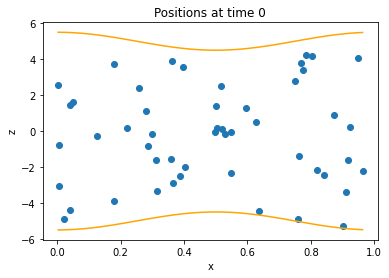

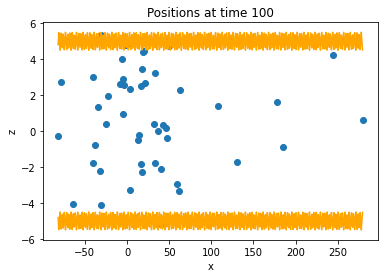

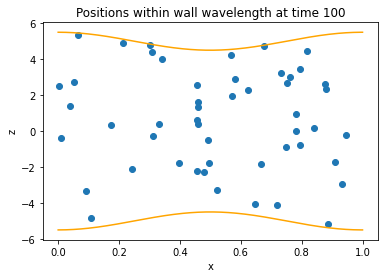

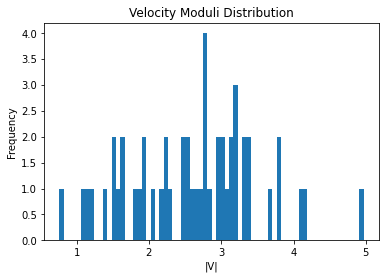

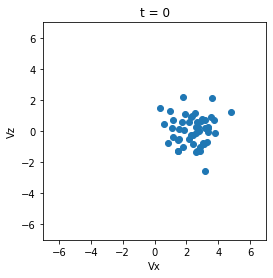

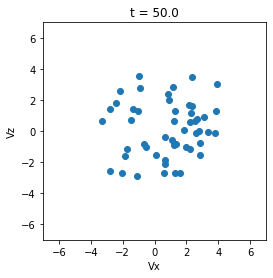

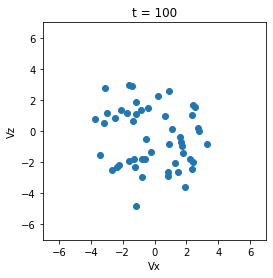

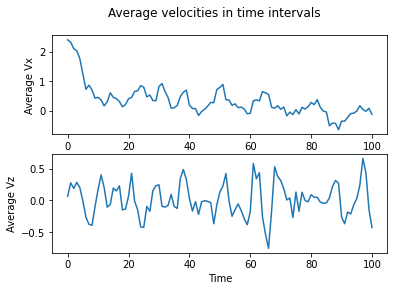

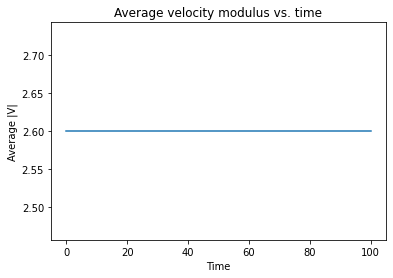

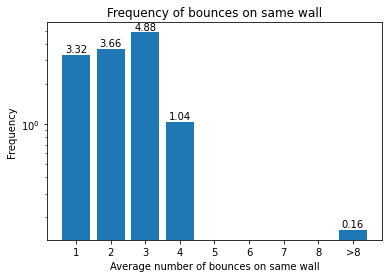

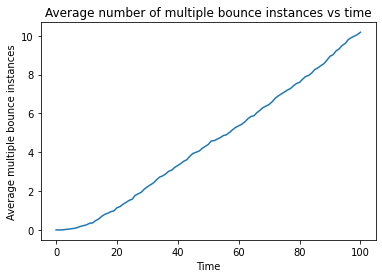

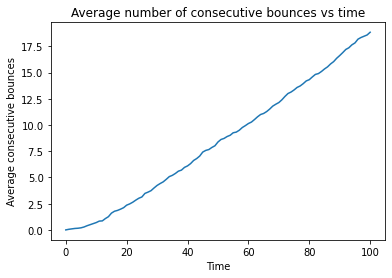

In [ ]:
'''
Main program.  
Sequence:
    1 - User can update the global simulation variables here if desired, 
    2 - Run the number of simulations in sequence
    3 - Analyse data and visualise the main information of interest

Last Modified Dec-04, 2020 (Jordan Hoffmann)
- Changed global variables to dictionaries
'''

# Lane geometry specifications
laneSpecs = dict(
    wallWavelength = 1.0,       # In units of length (1.0 for normalized units)
    wallAmplitude = 0.5,      # In units of length
    avgRadius = 5               # In units of length
)

# Particle motion initialization specifications
initCnsts = dict(
    initFlowVel = 2.5,          # In units of velocity
    velVariance = 1.0           # In units of velocity
)

# Runtime specifications common to a series of simulations
runSpecs = dict(
    singleRunTime = 100,        # In units of time     
    numHistBins = 70,  
    numTimeInts = 100,
    numSimRuns = 50,           # Number of particles simulated
    precision = 1e-6            # In units of length
)

# Output file name
fileName = "PSR_sim1_runData_" + str(laneSpecs["wallAmplitude"]) + "_"         \
           + str(laneSpecs["avgRadius"]) + "_" + str(initCnsts["initFlowVel"]) \
           + "_" + str(runSpecs["singleRunTime"]) + ".csv"

# Run the simulations
simulationData = run_sims(laneSpecs, initCnsts, runSpecs, fileName)

# Plot the last particle to ensure it looks correct
plot_last_trajectory(simulationData, laneSpecs, runSpecs)

# Plot analysis of the simulations
analyze_and_visualize(simulationData, laneSpecs, initCnsts, runSpecs)